# Deep Learning based Pipeline with Multichannel Inputs for Multi-label Patent Classification

This notebook describes a deep learning pipeline for automatic patent classification with multichannel inputs.  A neural network model is trained with multichannel inputs namely embeddings of different segments of patent texts, and sparse linear
input of different metadata. <br> <br>
<img src="arch_0000.png" height="600" width="700">

<br>
In this notebook the classification task is a multi-class classification. The basic outline is:  <br>  <br>


- load the patent dataset  <br>
- apply preprocessing tasks  <br>
- apply Tokenization process  <br>
- Load a pretrained word embeddings model  <br>
- prepare the embedding matrix for patent texts   <br>
- concatenated deep layers <br>
- train a deep neural network on the data  <br>
- Fit the model and show the results  <br>


#  Loading patent dataset
We established the training, and test datasets that are domain-specific datasets and related to information technology domain.
The total number of extracted records in the datasets is about 430,000  patents filed between 1978 and 2016. Each patent document contains a  patent number, issued date, patent type, and list of citations, classification codes, a list of inventors, a list of assignees, title, abstract, technical field, background,  summary of invention, and independent claim. <br>
The data det is availabe <a href=https://www.kaggle.com/darshmso/it-patent-dataset > HERE.<a/>


In [2]:
import pandas as pd

df = pd.read_csv("../datasets/allITPatTextWith_Metadata.csv",  encoding = "ISO-8859-1", error_bad_lines=False)
df.columns =['ID','TI','AB','TECHF','BACKG','SUMM','CLMS','ICM','AY','IPCs','REF','PA','INV']

#filter out rows with empty texts
df.dropna(subset=['IPCs'], inplace=True)
print("unique Count: ", df.count())


df.fillna(value='', inplace=True)

df.head()

unique Count:  ID       429711
TI       419219
AB       429700
TECHF    278387
BACKG    398251
SUMM     363176
CLMS     222262
ICM      429711
AY       429691
IPCs     429711
REF       25318
PA       301442
INV      429359
dtype: int64


,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPCs,REF,PA,INV
0,EP2000017943-0,recognition disk-shaped medium,recognition disk-like medium multimedia applic...,recognition disk-shaped medium multimedia appl...,identification labels adapted interpreted opti...,overcome drawbacks noted conventional types id...,,G06K0019-06,2000,"[G06K0019-06, G06K0007-10]",,Video_System_Italia_S_r_l,Tassello_Stefano
1,EP2003016733-0,optical pickup recording reproducing,optical pickup reproducing optical recording m...,optical pickup recording reproducing optical p...,recently practical short wavelength red laser ...,provide pickup recording reproducing optical r...,optical pickup recording reproducing optical m...,G11B0007-135,2000,"[G11B0007-135, G11B0007-125]",,Konica_Minolta_Opto_Inc,Arai_Norikazu Kojima_Toshiyuki Kiriki_Toshihik...
2,EP2011009984-0,large capacity sales mediation,animation sales mediation animation sales medi...,large capacity sales large capacity sales medi...,recent years distributing music network rapidl...,implemented consideration problems provide ani...,large capacity sales mediation terminal large ...,G07F0017-16,2001,"[G07F0017-16, G06Q0030-06, G06Q0020-10, G06Q00...","[JPHEI033290B, JPHEI08235759B, JPHEI10334048B,...",NEC_Corporation,Maeda_Koji
3,PCT1997010546-0,bridge client-server environment,software bridge introduced client client-serve...,bridge client-server environment distributed c...,overview object-oriented programming developme...,bridge client distributed object-oriented brid...,bridge client distributed object-oriented brid...,G06F009-46,1996,"[G06F009-46, G06F009-44, G06F0009-44, G06F0009...",,INTERNATIONAL_BUSINESS_MACHINES_CORPORATION CO...,COLYER_ADRIAN_MARK
4,PCT1998021641-0,sections operating rates,core clocked perform operations clock frequenc...,sections operating rates high speed processors...,illustrates microprocessor microprocessor incl...,microprocessor levels sub-core clocked frequen...,,G06F001-32,1997,"[G06F001-32, G06F0001-08, G06F0009-30, G06F000...",,,SAGER_DAVID_J FLETCHER_THOMAS_D HINTON_GLENN_J...


Text(0.5, 0, 'YEAR')

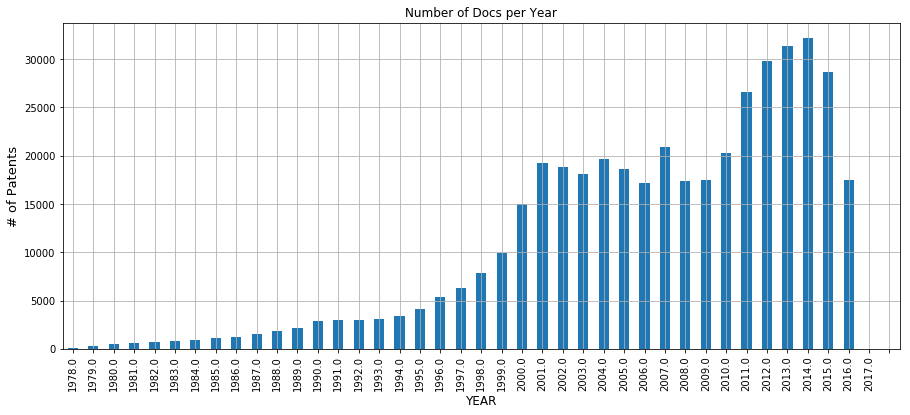

In [7]:
import matplotlib.pyplot as plt

df_AY = df.groupby(['AY'])
df_AY = df_AY.size().reset_index(name='Docs')


df_AY.plot(x='AY', y='Docs', kind='bar', legend=False, grid=True, figsize=(15, 6))
plt.title("Number of Docs per Year")
plt.ylabel('# of Patents', fontsize=13)
plt.xlabel('YEAR', fontsize=12)

# Applying preprocessing tasks on metadat of patent
Converting the metatadata such as inventors and assignees of each patent into a python list, then apply preprocessing task on each element in the list in order to remove undesired tokens.


In [5]:
%%time
#preprocess of list fields
#convert all IPCs in df into one list
def toList(s):
    """
    this method is to convert the list of IPCs in each row from a string to a python List
    """
    s  = s.translate ({ord(c): " " for c in "[]"})
    ss= []
    for cls in s.strip().split(','):
        ss.append(cls.strip())
    return ss

#apply toList method on all rows in the DF
df['PA'] = df['PA'].map(lambda pa :   toList(pa))
df['INV'] = df['INV'].map(lambda inv :   toList(inv))

df.head()  

CPU times: user 2.57 s, sys: 93.6 ms, total: 2.67 s
Wall time: 2.67 s


In [6]:
df.head()  

,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPCs,REF,PA,INV
0,EP2000017943-0,recognition disk-shaped medium,recognition disk-like medium multimedia applic...,recognition disk-shaped medium multimedia appl...,identification labels adapted interpreted opti...,overcome drawbacks noted conventional types id...,,G06K0019-06,2000,"[G06K0019-06, G06K0007-10]",,[Video_System_Italia_S_r_l],[Tassello_Stefano]
1,EP2003016733-0,optical pickup recording reproducing,optical pickup reproducing optical recording m...,optical pickup recording reproducing optical p...,recently practical short wavelength red laser ...,provide pickup recording reproducing optical r...,optical pickup recording reproducing optical m...,G11B0007-135,2000,"[G11B0007-135, G11B0007-125]",,[Konica_Minolta_Opto_Inc],[Arai_Norikazu Kojima_Toshiyuki Kiriki_Toshihi...
2,EP2011009984-0,large capacity sales mediation,animation sales mediation animation sales medi...,large capacity sales large capacity sales medi...,recent years distributing music network rapidl...,implemented consideration problems provide ani...,large capacity sales mediation terminal large ...,G07F0017-16,2001,"[G07F0017-16, G06Q0030-06, G06Q0020-10, G06Q00...","[JPHEI033290B, JPHEI08235759B, JPHEI10334048B,...",[NEC_Corporation],[Maeda_Koji]
3,PCT1997010546-0,bridge client-server environment,software bridge introduced client client-serve...,bridge client-server environment distributed c...,overview object-oriented programming developme...,bridge client distributed object-oriented brid...,bridge client distributed object-oriented brid...,G06F009-46,1996,"[G06F009-46, G06F009-44, G06F0009-44, G06F0009...",,[INTERNATIONAL_BUSINESS_MACHINES_CORPORATION C...,[COLYER_ADRIAN_MARK]
4,PCT1998021641-0,sections operating rates,core clocked perform operations clock frequenc...,sections operating rates high speed processors...,illustrates microprocessor microprocessor incl...,microprocessor levels sub-core clocked frequen...,,G06F001-32,1997,"[G06F001-32, G06F0001-08, G06F0009-30, G06F000...",,[],[SAGER_DAVID_J FLETCHER_THOMAS_D HINTON_GLENN_...


In [7]:
def IPCtoList(s):
    """
    this method is to convert the list of IPCs in each row from a string to a python List
    """
    s  = s.translate ({ord(c): " " for c in "[]"})
    ss= []
    for cls in s.strip().split(','):
        ss.append(cls.strip()[:4])
    return list(set(ss))

df['IPCs'] = df['IPCs'].map(lambda ipcs :   IPCtoList(ipcs))

df.head()  

,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPCs,REF,PA,INV
0,EP2000017943-0,recognition disk-shaped medium,recognition disk-like medium multimedia applic...,recognition disk-shaped medium multimedia appl...,identification labels adapted interpreted opti...,overcome drawbacks noted conventional types id...,,G06K0019-06,2000,[G06K],,[Video_System_Italia_S_r_l],[Tassello_Stefano]
1,EP2003016733-0,optical pickup recording reproducing,optical pickup reproducing optical recording m...,optical pickup recording reproducing optical p...,recently practical short wavelength red laser ...,provide pickup recording reproducing optical r...,optical pickup recording reproducing optical m...,G11B0007-135,2000,[G11B],,[Konica_Minolta_Opto_Inc],[Arai_Norikazu Kojima_Toshiyuki Kiriki_Toshihi...
2,EP2011009984-0,large capacity sales mediation,animation sales mediation animation sales medi...,large capacity sales large capacity sales medi...,recent years distributing music network rapidl...,implemented consideration problems provide ani...,large capacity sales mediation terminal large ...,G07F0017-16,2001,"[G07F, G06Q, H04L, G06F]","[JPHEI033290B, JPHEI08235759B, JPHEI10334048B,...",[NEC_Corporation],[Maeda_Koji]
3,PCT1997010546-0,bridge client-server environment,software bridge introduced client client-serve...,bridge client-server environment distributed c...,overview object-oriented programming developme...,bridge client distributed object-oriented brid...,bridge client distributed object-oriented brid...,G06F009-46,1996,[G06F],,[INTERNATIONAL_BUSINESS_MACHINES_CORPORATION C...,[COLYER_ADRIAN_MARK]
4,PCT1998021641-0,sections operating rates,core clocked perform operations clock frequenc...,sections operating rates high speed processors...,illustrates microprocessor microprocessor incl...,microprocessor levels sub-core clocked frequen...,,G06F001-32,1997,[G06F],,[],[SAGER_DAVID_J FLETCHER_THOMAS_D HINTON_GLENN_...


In [8]:
%%time

def metadataPreprocessing(input):
    newInput=' '
    for item in input:
        item = item.translate ({ord(c): " " for c in "!@#$%^&*()'[]{};:,./<>?\|`~°=\"+"})
        itms=' '
        for itm in item.split():
            itms= itms +' '+itm.strip()
        newInput = newInput + ' '+ itms.strip().replace(' ','_')
    return newInput.strip()

df['PA'] = df['PA'].map(lambda pa :   metadataPreprocessing(pa))
df['INV'] = df['INV'].map(lambda inv :   metadataPreprocessing(inv))

df.head()

CPU times: user 5.59 s, sys: 41.7 ms, total: 5.64 s
Wall time: 5.65 s


#  Applying preprocessing tasks on texts of patent
A simple preprocessing tasks such as tokenization, stopword removal, lemmatization, and converting letters into lower case are performed on each text section of each patent document.

In [9]:
#preprocessing 
standardStopwordFile = "sources/stopwords/stopwords-all.txt"

#loading terms from a file to a set
def get_terms_from_file(filePath):
    terms = set(line.strip() for line in open(filePath))
    return terms

#remove undiserd terms
def remove_terms(termSet, phrase):
    newPhrase = ""
    for term in phrase.split():
        if term.strip() not in termSet and len(term.strip())>2:
            newPhrase = newPhrase + " " + term.strip()



def clean_texts(doc):
    #Remove punctuation from texts
    doc = doc.translate ({ord(c): ' ' for c in "0123456789!@#$%^&*()'/[]{};:,./<>?\|`~°=\"+"})
    # split into tokens by white space
    tokens = doc.lower().strip().split()
    
    # filter out stop words
    stop_words = get_terms_from_file(standardStopwordFile)
    #generalStopwords = get_terms_from_file(generalWordsFile)

    
    tokens = [w.strip('-')  for w in tokens if  w not in stop_words ]
    # filter out short and long  tokens
    output = [word for word in tokens if len(word.strip()) > 2 and len(word) < 30 ]
    output = " ".join(output)
    #apply stemming
    #output = stem_text(output)
    return output



In [10]:
%%time
apply simple preprocessing on text
df['TI'] = df['TI'].map(lambda line : clean_texts(line))
df['AB'] = df['AB'].map(lambda line : clean_texts(line))
df['TECHF'] = df['TECHF'].map(lambda line : clean_texts(line))
df['BACKG'] = df['BACKG'].map(lambda line : clean_texts(line))
df['SUMM'] = df['SUMM'].map(lambda line : clean_texts(line))
df['CLMS'] = df['CLMS'].map(lambda line : clean_texts(line))


df.head()

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 8.82 µs


#  Applying preprocessing tasks on patent labels ( IPC codes)
The main IPC codes is considered to be the labels for the patent documents. we only consider the subclass level of the IPC code. 
Each label/class appears at least more than 3000 times.

In [11]:
import collections

#get a list of all unique IPCs
IPCsDF = pd.DataFrame(df['IPCs'])
ipcsList = [ipc for ipcs in IPCsDF['IPCs']  for ipc in ipcs]

print('The number of all IPCs in the dataset is: ', len(ipcsList))


IPCsDic = collections.Counter(ipcsList)
uniqueIPCsList = [x[0] for x in IPCsDic.items() if x[1] >= 3000]

print('The number of unique filtered IPCs to be used as labels is: ',len(uniqueIPCsList))

The number of all IPCs in the dataset is:  774686
The number of unique filtered IPCs to be used as labels is:  31


In [12]:
#update the dataset (DF) according to te unique filtered IPCs 
def filterOutIPCs(docIPCList, uniqueALlIPCList):
    """
    this method is to filter out all IPcs according to te unique filtered IPCs 
    """
    
    newIPCList= []
    for cls in docIPCList:
        if cls in uniqueALlIPCList:
            newIPCList.append(cls.strip())
    if not newIPCList:
        return None
    
    return newIPCList

#apply filterOutIPCs method on all rows in the DF
df['IPCs'] = df['IPCs'].map(lambda ipcs :   filterOutIPCs(ipcs, uniqueIPCsList))

df.head()

,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPCs,REF,PA,INV
0,EP2000017943-0,recognition disk-shaped medium,recognition disk-like medium multimedia applic...,recognition disk-shaped medium multimedia appl...,identification labels adapted interpreted opti...,overcome drawbacks noted conventional types id...,,G06K0019-06,2000,[G06K],,Video_System_Italia_S_r_l,Tassello_Stefano
1,EP2003016733-0,optical pickup recording reproducing,optical pickup reproducing optical recording m...,optical pickup recording reproducing optical p...,recently practical short wavelength red laser ...,provide pickup recording reproducing optical r...,optical pickup recording reproducing optical m...,G11B0007-135,2000,[G11B],,Konica_Minolta_Opto_Inc,Arai_Norikazu_Kojima_Toshiyuki_Kiriki_Toshihik...
2,EP2011009984-0,large capacity sales mediation,animation sales mediation animation sales medi...,large capacity sales large capacity sales medi...,recent years distributing music network rapidl...,implemented consideration problems provide ani...,large capacity sales mediation terminal large ...,G07F0017-16,2001,"[G07F, G06Q, H04L, G06F]","[JPHEI033290B, JPHEI08235759B, JPHEI10334048B,...",NEC_Corporation,Maeda_Koji
3,PCT1997010546-0,bridge client-server environment,software bridge introduced client client-serve...,bridge client-server environment distributed c...,overview object-oriented programming developme...,bridge client distributed object-oriented brid...,bridge client distributed object-oriented brid...,G06F009-46,1996,[G06F],,INTERNATIONAL_BUSINESS_MACHINES_CORPORATION_CO...,COLYER_ADRIAN_MARK
4,PCT1998021641-0,sections operating rates,core clocked perform operations clock frequenc...,sections operating rates high speed processors...,illustrates microprocessor microprocessor incl...,microprocessor levels sub-core clocked frequen...,,G06F001-32,1997,[G06F],,,SAGER_DAVID_J_FLETCHER_THOMAS_D_HINTON_GLENN_J...


In [13]:
#again filter out rows with empty texts
df.dropna(subset=['IPCs'], inplace=True)
print("unique Count: ", df.count())

unique Count:  ID       420787
TI       420787
AB       420787
TECHF    420787
BACKG    420787
SUMM     420787
CLMS     420787
ICM      420787
AY       420787
IPCs     420787
REF      420787
PA       420787
INV      420787
dtype: int64


# Randomly reorder a dataset by rows

In [14]:
from sklearn.utils import shuffle

df = shuffle(df)

df.head()

,ID,TI,AB,TECHF,BACKG,SUMM,CLMS,ICM,AY,IPCs,REF,PA,INV
28536,PCT2000077740-0,geometric compression three-dimensional graphics,compressing geometry capable compressing regul...,geometric compression three-dimensional graphi...,three-dimensional graphics systems employing l...,problems outlined solved compressing geometry ...,,G06T009-00,2000,[G06T],,,DEERING_MICHAEL_F
28135,PCT2013133985-0,entity augmentation latent relational,directed providing augmenting entity-attribute...,,entity augmentation latent relational workers ...,provided introduce representative concepts sim...,computing environment performed augmentation a...,G06F0017-00,2013,[G06F],,MICROSOFT_CORPORATION,GANJAM_Kris_K_CHAKRABARTI_Kaushik_YAKOUT_Moham...
185746,PCT2003010617-0,methods equipment analysing biological signals...,concerns representing analysing pressure varia...,,processes equipment analysis biological signal...,aims addressing providing representation analy...,system representation analysis pressure variab...,G06F,2002,"[G06F, A61B]",,,LEMAIRE_JEAN-JACQUES
39935,PCT2002003177-0,identifying persons seeking computers networks,verifying identity seeking directly network pr...,identifying persons seeking computers networks...,security violations databases constitute major...,primarily serve positively identify seeking di...,verifying identity seeking gain local communic...,G06F001-00,2001,"[G06F, H04L]",,,DOR_EREZ_DRACH_ZIPORA
31628,PCT2003098393-0,routing securely share network host utilizing ...,providing selectively share network routing ho...,,routing securely sharenetwork host utilizing h...,provide restricting host accessing network int...,claimed node wireless ad-hoc communications ne...,G06F,2003,"[G06F, H04W, H04L]",,,SCHMIDT_JEFFREY_GUTIERREZ_PHILIP_BARKER_JR_CHA...


# split the dataset into train and test datasets

In [15]:
# lets take n% data as training and remaining m% for test.
train_size = int(len(df) * .8)

train_TI = df['TI'][:train_size]
train_AB = df['AB'][:train_size]
train_TECHF = df['TECHF'][:train_size]
train_BACKG = df['BACKG'][:train_size]
train_SUMM = df['SUMM'][:train_size]
train_CLMS = df['CLMS'][:train_size]
train_ICM= df['IPCs'][:train_size]
train_ID= df['ID'][:train_size]

test_TI = df['TI'][train_size:]
test_AB = df['AB'][train_size:]
test_TECHF = df['TECHF'][train_size:]
test_BACKG = df['BACKG'][train_size:]
test_SUMM = df['SUMM'][train_size:]
test_CLMS = df['CLMS'][train_size:]
test_ICM = df['IPCs'][train_size:]
test_ID = df['ID'][train_size:]


#metadata
train_pa_series = df['PA'][:train_size]
test_pa_series = df['PA'][train_size:]

train_inv_series = df['INV'][:train_size]
test_inv_series = df['INV'][train_size:]


print(train_AB.shape)
print(test_AB.shape)

#free up some memory space
#df.iloc[0:0]

(336629,)
(84158,)


#  Applying tokenization process 
For texts of each segment, a Keras tokenization process is used for breaking the text into individual words, and  set the sequence length of each segment according to the length of each.


In [16]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from sklearn.preprocessing import LabelBinarizer


Using TensorFlow backend.


Applying Keras tokenization on Metadata of patent(Inventors, Assignees), and convert the related text into One-hot that encodes a text into a list of word indexes of size n.

In [17]:
#PA
pa_inv_vocab_size = 2000
pa_tokenizer = Tokenizer(num_words=pa_inv_vocab_size,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~', lower=True, split=' ', char_level=False, oov_token=None)
pa_tokenizer.fit_on_texts(train_pa_series)
train_pa_one_hot =pa_tokenizer.texts_to_matrix(train_pa_series)
test_pa_one_hot =pa_tokenizer.texts_to_matrix(test_pa_series)


#INV
inv_tokenizer = Tokenizer(num_words=pa_inv_vocab_size,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~', lower=True, split=' ', char_level=False, oov_token=None)
inv_tokenizer.fit_on_texts(train_inv_series)
train_inv_one_hot =inv_tokenizer.texts_to_matrix(train_inv_series)
test_inv_one_hot =inv_tokenizer.texts_to_matrix(test_inv_series)


print('Found %s words in PA' % len(pa_tokenizer.word_index))
print('Found %s words in INV' % len(inv_tokenizer.word_index))

Found 91324 words in PA
Found 264576 words in INV


<br>
- Transform each text in Titles (train and test datasets) into a sequence of integers. <br>
- set the sequence length.<br>
- Pads sequences to the same length.<br>



In [18]:
%%time

#Title
TI_tokenizer = Tokenizer(num_words=10000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
TI_tokenizer.fit_on_texts(train_TI)
encoded_train_TI = TI_tokenizer.texts_to_sequences(train_TI)
encoded_test_TI = TI_tokenizer.texts_to_sequences(test_TI)
#convert all sequences in a list into the same length
TI_train = pad_sequences(encoded_train_TI,  maxlen=20, padding='post')
TI_test = pad_sequences(encoded_test_TI,  maxlen=20, padding='post')


CPU times: user 10.3 s, sys: 64.3 ms, total: 10.3 s
Wall time: 10.3 s


<br>
Transform each text in Abstrcat (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [19]:
%%time
#Abstract
AB_tokenizer = Tokenizer(num_words=50000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
AB_tokenizer.fit_on_texts(train_AB)
encoded_train_AB = AB_tokenizer.texts_to_sequences(train_AB)
encoded_test_AB = AB_tokenizer.texts_to_sequences(test_AB)
#convert all sequences in a list into the same length
AB_train = pad_sequences(encoded_train_AB,  maxlen=100, padding='post')
AB_test = pad_sequences(encoded_test_AB,  maxlen=100, padding='post')


CPU times: user 28.7 s, sys: 311 ms, total: 29 s
Wall time: 29.1 s


<br>
Transform each text in Technical Field (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [20]:
%%time
#TECHNICAL_FIELD
TECHF_tokenizer = Tokenizer(num_words=20000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
TECHF_tokenizer.fit_on_texts(train_TECHF)
encoded_train_TECHF = TECHF_tokenizer.texts_to_sequences(train_TECHF)
encoded_test_TECHF = TECHF_tokenizer.texts_to_sequences(test_TECHF)
#convert all sequences in a list into the same length
TECHF_train = pad_sequences(encoded_train_TECHF,  maxlen=30, padding='post')
TECHF_test = pad_sequences(encoded_test_TECHF,  maxlen=30, padding='post')


CPU times: user 18.2 s, sys: 145 ms, total: 18.3 s
Wall time: 18.4 s


<br>
Transform each text in Background (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [21]:
%%time
#BACKGROUND
BACKG_tokenizer = Tokenizer(num_words=50000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
BACKG_tokenizer.fit_on_texts(train_BACKG)
encoded_train_BACKG = BACKG_tokenizer.texts_to_sequences(train_BACKG)
encoded_test_BACKG = BACKG_tokenizer.texts_to_sequences(test_BACKG)
#convert all sequences in a list into the same length
BACKG_train = pad_sequences(encoded_train_BACKG,  maxlen=100, padding='post')
BACKG_test = pad_sequences(encoded_test_BACKG,  maxlen=100, padding='post')


CPU times: user 2min 3s, sys: 1 s, total: 2min 4s
Wall time: 2min 5s


<br>
Transform each text in Summary (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [22]:
%%time
#SUMMARY
SUMM_tokenizer = Tokenizer(num_words=50000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
SUMM_tokenizer.fit_on_texts(train_SUMM)
encoded_train_SUMM = SUMM_tokenizer.texts_to_sequences(train_SUMM)
encoded_test_SUMM = SUMM_tokenizer.texts_to_sequences(test_SUMM)
#convert all sequences in a list into the same length
SUMM_train = pad_sequences(encoded_train_SUMM,  maxlen=100, padding='post')
SUMM_test = pad_sequences(encoded_test_SUMM,  maxlen=100, padding='post')


CPU times: user 2min 43s, sys: 1.19 s, total: 2min 44s
Wall time: 2min 44s


<br>
Transform each text in Independent Claim (train and test datasets) into a sequence of integers. <br>
set the sequence length.<br>
Pads sequences to the same length.<br>



In [23]:
%%time
#CLAIMS
CLMS_tokenizer = Tokenizer(num_words=50000,  filters='!"#$%&()*+,./:;<=>?@[\]^`{|}~_', lower=True, split=' ', char_level=False, oov_token=None)
CLMS_tokenizer.fit_on_texts(train_CLMS)
encoded_train_CLMS = CLMS_tokenizer.texts_to_sequences(train_CLMS)
encoded_test_CLMS = CLMS_tokenizer.texts_to_sequences(test_CLMS)
#convert all sequences in a list into the same length
CLMS_train = pad_sequences(encoded_train_CLMS,  maxlen=100, padding='post')
CLMS_test = pad_sequences(encoded_test_CLMS,  maxlen=100, padding='post')


CPU times: user 39.5 s, sys: 845 ms, total: 40.3 s
Wall time: 40.4 s


<br>
Representing the labels/classes in the numeric format by scikit-learn - MultiLabelBinarizer class. <br>
Convert 1-dimensional class arrays to n-dimensional(#classes) class matrices.

In [24]:
%%time
from sklearn.preprocessing import MultiLabelBinarizer

multiLabelBinarizer =  MultiLabelBinarizer(classes=uniqueIPCsList)


y_train = multiLabelBinarizer.fit_transform(train_ICM)
y_test = multiLabelBinarizer.fit_transform(test_ICM)

num_classes = len(uniqueIPCsList)


CPU times: user 655 ms, sys: 70.8 ms, total: 726 ms
Wall time: 725 ms


#  load the whole embeddings model into memory and get matrix
We load a pre-trained word2vec word embedding model that was trained on five million patents (Titles and abstracts) <br>

The Embeddings model is availabel <a href=https://www.kaggle.com/darshmso/w2vec-patent-domain > here.</a>


In [25]:
import numpy as np

def load_embedding_model(filePath):
    embeddings_index = dict()
    f = open(filePath, encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
    return embeddings_index

def create_embedding_matrix(tokenizer, embeddings_index, vocab_size_embbs, dim_size):
    embeddings_matrix = np.zeros((vocab_size_embbs, dim_size))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector[0:dim_size]
    
    return embeddings_matrix


 Loading the whole embeddings into memory and get matrix

In [26]:
%%time

embedding_index = load_embedding_model('../models/w2v/phrase/patWordPhrase2VecModel.txt')


CPU times: user 1min 28s, sys: 2.6 s, total: 1min 30s
Wall time: 1min 30s


<br>
Creating TITLE embeddings Matrix

In [27]:
%%time

#vocab_size for embedding
vocab_size_embb = len(TI_tokenizer.word_index) + 1

TI_embeddings_matrix = create_embedding_matrix(TI_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              20)




CPU times: user 84.6 ms, sys: 54.9 ms, total: 139 ms
Wall time: 138 ms



Creating ABSTRACT embeddings Matrix

In [28]:
%%time

#vocab_size for embedding
vocab_size_embb = len(AB_tokenizer.word_index) + 1
AB_embeddings_matrix = create_embedding_matrix(AB_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)


CPU times: user 240 ms, sys: 109 ms, total: 349 ms
Wall time: 349 ms


Creating TECHNICAL_FIELD embedding Matrix

In [29]:
%%time

#vocab_size for embedding
vocab_size_embb = len(TECHF_tokenizer.word_index) + 1
TECHF_embeddings_matrix = create_embedding_matrix(TECHF_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              30)

CPU times: user 160 ms, sys: 25 ms, total: 185 ms
Wall time: 184 ms


Creating BACKGROUND embedding Matrix

In [30]:
%%time

#vocab_size for embedding
vocab_size_embb = len(BACKG_tokenizer.word_index) + 1
BACKG_embeddings_matrix = create_embedding_matrix(BACKG_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)

CPU times: user 556 ms, sys: 192 ms, total: 749 ms
Wall time: 749 ms


Creating SUMMARY embeddings Matrix

In [31]:
%%time

#vocab_size for embedding
vocab_size_embb = len(SUMM_tokenizer.word_index) + 1
SUMM_embeddings_matrix = create_embedding_matrix(SUMM_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)

CPU times: user 523 ms, sys: 165 ms, total: 688 ms
Wall time: 689 ms


Creating INDEPENDENT CLAIMS embeddings Matrix

In [32]:
%%time

#vocab_size for embedding
vocab_size_embb = len(CLMS_tokenizer.word_index) + 1
CLMS_embeddings_matrix = create_embedding_matrix(CLMS_tokenizer,
                                              embedding_index,
                                              vocab_size_embb,
                                              100)

CPU times: user 176 ms, sys: 50.9 ms, total: 227 ms
Wall time: 226 ms


# Creating a Deep Layer for each Input

In [33]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Embedding, BatchNormalization, ELU, Concatenate
from keras.layers import LSTM, Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout


<br> Creating LSTM deep layer for Title Embeddings<br>

In [34]:
%%time
#TITLE 
sequence_len =20
dropout_pct =  0.3

TI_embedding_layer_input = Input(shape=(sequence_len,), name='TI_embed_input')
TI_embedding_layer = Embedding(input_dim=len(TI_tokenizer.word_index) + 1,
                        output_dim=20, # Dimension of the dense embedding
                        weights=[TI_embeddings_matrix],
                        input_length=20)(TI_embedding_layer_input)

lstm_size = 64
TI_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_TI')(TI_embedding_layer)

TI_deep = Dense(300, activation=None)(TI_deep)
TI_deep = Dropout(dropout_pct)(TI_deep)
TI_deep = BatchNormalization()(TI_deep)
TI_deep = ELU()(TI_deep)


CPU times: user 4.65 s, sys: 8.49 s, total: 13.1 s
Wall time: 4.02 s


<br> Creating LSTM deep layer for Abstract Embeddings<br>


In [35]:
%%time
#Abstract 
sequence_len =100
dropout_pct =  0.3

AB_embedding_layer_input = Input(shape=(sequence_len,), name='AB_embed_input')
AB_embedding_layer = Embedding(input_dim=len(AB_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[AB_embeddings_matrix],
                        input_length=100)(AB_embedding_layer_input)

lstm_size = 64
AB_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_AB')(AB_embedding_layer)

AB_deep = Dense(300, activation=None)(AB_deep)
AB_deep = Dropout(dropout_pct)(AB_deep)
AB_deep = BatchNormalization()(AB_deep)
AB_deep = ELU()(AB_deep)


CPU times: user 3.42 s, sys: 6.4 s, total: 9.82 s
Wall time: 754 ms


<br> Creating LSTM deep layer for TECHNICAL-Field Embeddings<br>


In [36]:
%%time
#TECHNICAL-Field 
sequence_len =30
dropout_pct =  0.3

TECHF_embedding_layer_input = Input(shape=(sequence_len,), name='TECHF_embed_input')
TECHF_embedding_layer = Embedding(input_dim=len(TECHF_tokenizer.word_index) + 1,
                        output_dim=30, # Dimension of the dense embedding
                        weights=[TECHF_embeddings_matrix],
                        input_length=30)(TECHF_embedding_layer_input)

lstm_size = 64
TECHF_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_TECHF')(TECHF_embedding_layer)

TECHF_deep = Dense(300, activation=None)(TECHF_deep)
TECHF_deep = Dropout(dropout_pct)(TECHF_deep)
TECHF_deep = BatchNormalization()(TECHF_deep)
TECHF_deep = ELU()(TECHF_deep)

CPU times: user 3.56 s, sys: 6.17 s, total: 9.72 s
Wall time: 667 ms


<br> Creating LSTM deep layer for BACKGROUND Embeddings<br>

In [37]:
%%time
#BACKGROUND 
sequence_len =100
dropout_pct =  0.3

BACKG_embedding_layer_input = Input(shape=(sequence_len,), name='BACKG_embed_input')
BACKG_embedding_layer = Embedding(input_dim=len(BACKG_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[BACKG_embeddings_matrix],
                        input_length=100)(BACKG_embedding_layer_input)

lstm_size = 64
BACKG_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_BACK')(BACKG_embedding_layer)

BACKG_deep = Dense(300, activation=None)(BACKG_deep)
BACKG_deep = Dropout(dropout_pct)(BACKG_deep)
BACKG_deep = BatchNormalization()(BACKG_deep)
BACKG_deep = ELU()(BACKG_deep)

CPU times: user 3.81 s, sys: 7.12 s, total: 10.9 s
Wall time: 1.85 s


<br> Creating LSTM deep layer for Summary Embeddings<br>

In [38]:
%%time
#SUMMARY
sequence_len =100
dropout_pct =  0.3

SUMM_embedding_layer_input = Input(shape=(sequence_len,), name='SUMM_embed_input')
SUMM_embedding_layer = Embedding(input_dim=len(SUMM_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[SUMM_embeddings_matrix],
                        input_length=100)(SUMM_embedding_layer_input)

lstm_size = 64
SUMM_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_SUMM')(SUMM_embedding_layer)

SUMM_deep = Dense(300, activation=None)(SUMM_deep)
SUMM_deep = Dropout(dropout_pct)(SUMM_deep)
SUMM_deep = BatchNormalization()(SUMM_deep)
SUMM_deep = ELU()(SUMM_deep)

CPU times: user 3.85 s, sys: 6.52 s, total: 10.4 s
Wall time: 1.3 s


<br> Creating LSTM deep layer for Independent Claim Embeddings<br>

In [39]:
%%time
#CLAIMS 
sequence_len =100
dropout_pct =  0.4


CLMS_embedding_layer_input = Input(shape=(sequence_len,), name='CLMS_embed_input')
CLMS_embedding_layer = Embedding(input_dim=len(CLMS_tokenizer.word_index) + 1,
                        output_dim=100, # Dimension of the dense embedding
                        weights=[CLMS_embeddings_matrix],
                        input_length=100)(CLMS_embedding_layer_input)

lstm_size = 64
CLMS_deep = LSTM(lstm_size,
            dropout=dropout_pct,
            recurrent_dropout=dropout_pct,
            return_sequences=False,
            name='LSTM_CLMS')(CLMS_embedding_layer)

CLMS_deep = Dense(300, activation=None)(CLMS_deep)
CLMS_deep = Dropout(dropout_pct)(CLMS_deep)
CLMS_deep = BatchNormalization()(CLMS_deep)
CLMS_deep = ELU()(CLMS_deep)

CPU times: user 3.75 s, sys: 6.27 s, total: 10 s
Wall time: 948 ms


<br> Creating LSTM deep layers for one-hot vectors of Inventors and Assignees<br>

In [40]:
dropout_pct =  0.3
pa_input = Input(shape=(train_pa_one_hot.shape[1],), name='pa_input') 
pas = Dense(32,input_dim=train_pa_one_hot.shape[1], activation=None)(pa_input) 
pas = Dropout(dropout_pct)(pas)
pas = BatchNormalization()(pas)
pas = ELU()(pas)

#inv
inv_input = Input(shape=(train_inv_one_hot.shape[1],), name='inv_input') 
invs = Dense(32,input_dim=train_inv_one_hot.shape[1], activation=None)(pa_input) 
invs = Dropout(dropout_pct)(invs)
invs = BatchNormalization()(invs)

print('pa_input and inv_input layers are finished')

pa_input and inv_input layers are finished


# Train Model
The following cells specify the neural network architecture and hyperparameters. <br>

The model is generally composed of:<br>

- contacting sequential word embeddings ofpatent text segments into a fully-connected layer
-  binary_crossentropy is used for calculatinges the mean accuracy rate across all predictions for multi-label classification problems <br>
- Compile the  the Network. <br>


In [41]:
import keras_metrics as km
#contacting 
model_inputs_to_concat = [TI_deep, AB_deep, TECHF_deep, BACKG_deep, SUMM_deep, CLMS_deep] #invs , pas, invs
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='sigmoid')(output)

model = Model(inputs=[TI_embedding_layer_input,
                      AB_embedding_layer_input,
                      TECHF_embedding_layer_input,
                      BACKG_embedding_layer_input,
                     SUMM_embedding_layer_input,
                     CLMS_embedding_layer_input,
                     ],
              outputs=output, name='model')

# Calculate precision for the second label.
precision = km.binary_precision(label=1)

# Calculate recall for the first label.
recall = km.binary_recall(label=0)

model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy', precision, recall])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
AB_embed_input (InputLayer)     (None, 100)          0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
BACKG_embed_input (InputLayer)  (None, 100)          0                                            
__________________________________________________________________________________________________
SUMM_embed

Train / Fit the Network

In [ ]:
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

<br>Train the neural network on  multichannel inputs namely deep layers of patent text segments 
 and deep layers of patent metadata.<br>

In [ ]:
import keras_metrics as km

#contacting two input models
model_inputs_to_concat = [TI_deep, AB_deep, TECHF_deep, BACKG_deep, SUMM_deep, CLMS_deep, pas, invs] 
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='sigmoid')(output)

model2 =Model(inputs=[ TI_embedding_layer_input,
                      AB_embedding_layer_input,
                      TECHF_embedding_layer_input,
                      BACKG_embedding_layer_input,
                     SUMM_embedding_layer_input,
                     CLMS_embedding_layer_input,
                     pa_input,
                      inv_input],
              outputs=output, name='model')
model2.compile(loss='binary_crossentropy',
                      optimizer='adam',
                       metrics=['accuracy', km.categorical_precision(), km.categorical_recall()])
model2.summary()

Fit the model/network

In [ ]:
%%time
batch_size= 500 
num_epochs = 10


history2 = model2.fit(x={'TI_embed_input': TI_train,
                         'AB_embed_input': AB_train,
             'TECHF_embed_input': TECHF_train,
             'BACKG_embed_input': BACKG_train,
             'SUMM_embed_input': SUMM_train,
             'CLMS_embed_input': CLMS_train,
             'pa_input': train_pa_one_hot,
             'inv_input': train_inv_one_hot
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test,
             'BACKG_embed_input': BACKG_test,
             'SUMM_embed_input': SUMM_test,
            'CLMS_embed_input': CLMS_test,
            'pa_input': test_pa_one_hot,
            'inv_input': test_inv_one_hot
            },
           y_test))

# Evaluation of Multi-label Classification 
We actually used the code availab el <a href=https://github.com/tensorflow/tensorflow/issues/28074 >here </a> as a metrics for multi-label classification for using Keras.

In [45]:


class MetricsAtTopK:
    def __init__(self, k):
        self.k = k

    def _get_prediction_tensor(self, y_pred):
        """Takes y_pred and creates a tensor of same shape with 1 in indices where, the values are in top_k
        """
        topk_values, topk_indices = tf.nn.top_k(y_pred, k=self.k, sorted=False, name="topk")
        # the topk_indices are along last axis (1). Add indices for axis=0
        ii, _ = tf.meshgrid(tf.range(tf.shape(y_pred)[0]), tf.range(self.k), indexing='ij')
        index_tensor = tf.reshape(tf.stack([ii, topk_indices], axis=-1), shape=(-1, 2))
        prediction_tensor = tf.sparse_to_dense(sparse_indices=index_tensor,
                                               output_shape=tf.shape(y_pred),
                                               default_value=0,
                                               sparse_values=1.0,
                                               validate_indices=False
                                               )
        prediction_tensor = tf.cast(prediction_tensor, K.floatx())
        return prediction_tensor

    def true_positives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        return true_positive

    def false_positives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c2 = K.sum(prediction_tensor)  # TP + FP
        false_positive = c2 - true_positive
        return false_positive

    def false_negatives_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c3 = K.sum(y_true)  # TP + FN
        false_negative = c3 - true_positive
        return false_negative

    def precision_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c2 = K.sum(prediction_tensor)  # TP + FP
        return true_positive/(c2+K.epsilon())

    def recall_at_k(self, y_true, y_pred):
        prediction_tensor = self._get_prediction_tensor(y_pred=y_pred)
        true_positive = K.sum(tf.multiply(prediction_tensor, y_true))
        c3 = K.sum(y_true)  # TP + FN
        return true_positive/(c3+K.epsilon())

    def f1_at_k(self, y_true, y_pred):
        precision = self.precision_at_k(y_true=y_true, y_pred=y_pred)
        recall = self.recall_at_k(y_true=y_true, y_pred=y_pred)
        f1 = (2*precision*recall)/(precision+recall+K.epsilon())
        return f1

In [46]:
### Usage:
metrics = MetricsAtTopK(k=5)
# model definition
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 
                                                                     metrics.true_positives_at_k, 
                                                                     metrics.false_positives_at_k,
                                                                     metrics.false_negatives_at_k,
                                                                     metrics.recall_at_k,
                                                                     metrics.precision_at_k,
                                                                     metrics.f1_at_k,
                                                                    ])
model.summary()

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
AB_embed_input (InputLayer)     (None, 100)          0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
BACKG_embed_input (InputLayer)  (None, 100)          0                                            
__________

In [47]:
%%time
batch_size= 500 
num_epochs = 10

history = model.fit(x={'TI_embed_input': TI_train,
                       'AB_embed_input': AB_train,
             'TECHF_embed_input': TECHF_train,
             'BACKG_embed_input': BACKG_train,
             'SUMM_embed_input': SUMM_train,
             'CLMS_embed_input': CLMS_train
             
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test,
             'BACKG_embed_input': BACKG_test,
             'SUMM_embed_input': SUMM_test,
            'CLMS_embed_input': CLMS_test
            },
           y_test))


Train on 336629 samples, validate on 84158 samples
Epoch 1/10
336629/336629 [==============================] - 457s 1ms/step - loss: 0.0804 - acc: 0.9710 - true_positives_at_k: 715.3929 - false_positives_at_k: 1783.8963 - false_negatives_at_k: 72.7587 - recall_at_k: 0.9078 - precision_at_k: 0.2862 - f1_at_k: 0.4352 - val_loss: 0.0820 - val_acc: 0.9695 - val_true_positives_at_k: 725.5607 - val_false_positives_at_k: 1771.2290 - val_false_negatives_at_k: 65.9321 - val_recall_at_k: 0.9168 - val_precision_at_k: 0.2906 - val_f1_at_k: 0.4413
Epoch 2/10
336629/336629 [==============================] - 442s 1ms/step - loss: 0.0794 - acc: 0.9712 - true_positives_at_k: 717.1670 - false_positives_at_k: 1782.1222 - false_negatives_at_k: 70.9945 - recall_at_k: 0.9100 - precision_at_k: 0.2869 - f1_at_k: 0.4363 - val_loss: 0.0806 - val_acc: 0.9701 - val_true_positives_at_k: 726.1545 - val_false_positives_at_k: 1770.6351 - val_false_negatives_at_k: 65.3383 - val_recall_at_k: 0.9176 - val_precision_at_k

In [49]:


#contacting two input models
model_inputs_to_concat = [TI_deep, AB_deep, TECHF_deep, BACKG_deep, SUMM_deep, CLMS_deep, pas, invs] 
final_layer =  Concatenate(name='concatenated_layer')(model_inputs_to_concat)

output = Dense(128, activation=None)(final_layer)
output = Dropout(dropout_pct)(output)
output = BatchNormalization()(output)
output = ELU()(output)
output = Dense(num_classes, activation='sigmoid')(output)

model2 =Model(inputs=[ TI_embedding_layer_input,
                      AB_embedding_layer_input,
                      TECHF_embedding_layer_input,
                      BACKG_embedding_layer_input,
                     SUMM_embedding_layer_input,
                     CLMS_embedding_layer_input,
                     pa_input,
                      inv_input],
              outputs=output, name='model')

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 
                                                                     metrics.true_positives_at_k, 
                                                                     metrics.false_positives_at_k,
                                                                     metrics.false_negatives_at_k,
                                                                     metrics.recall_at_k,
                                                                     metrics.precision_at_k,
                                                                     metrics.f1_at_k,
                                                                    ])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
TI_embed_input (InputLayer)     (None, 20)           0                                            
__________________________________________________________________________________________________
AB_embed_input (InputLayer)     (None, 100)          0                                            
__________________________________________________________________________________________________
TECHF_embed_input (InputLayer)  (None, 30)           0                                            
__________________________________________________________________________________________________
BACKG_embed_input (InputLayer)  (None, 100)          0                                            
__________________________________________________________________________________________________
SUMM_embed

In [50]:
%%time
batch_size= 500 
num_epochs = 10


history2 = model2.fit(x={'TI_embed_input': TI_train,
                         'AB_embed_input': AB_train,
             'TECHF_embed_input': TECHF_train,
             'BACKG_embed_input': BACKG_train,
             'SUMM_embed_input': SUMM_train,
             'CLMS_embed_input': CLMS_train,
             'pa_input': train_pa_one_hot,
             'inv_input': train_inv_one_hot
            },
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=
          ({'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test,
             'BACKG_embed_input': BACKG_test,
             'SUMM_embed_input': SUMM_test,
            'CLMS_embed_input': CLMS_test,
            'pa_input': test_pa_one_hot,
            'inv_input': test_inv_one_hot
            },
           y_test))

Train on 336629 samples, validate on 84158 samples
Epoch 1/10
336629/336629 [==============================] - 467s 1ms/step - loss: 0.1251 - acc: 0.9578 - true_positives_at_k: 691.7435 - false_positives_at_k: 1807.5457 - false_negatives_at_k: 96.3883 - recall_at_k: 0.8778 - precision_at_k: 0.2768 - f1_at_k: 0.4208 - val_loss: 0.0775 - val_acc: 0.9724 - val_true_positives_at_k: 730.3311 - val_false_positives_at_k: 1766.4585 - val_false_negatives_at_k: 61.1616 - val_recall_at_k: 0.9228 - val_precision_at_k: 0.2925 - val_f1_at_k: 0.4442
Epoch 2/10
336629/336629 [==============================] - 440s 1ms/step - loss: 0.0769 - acc: 0.9725 - true_positives_at_k: 722.5263 - false_positives_at_k: 1776.7629 - false_negatives_at_k: 65.6055 - recall_at_k: 0.9169 - precision_at_k: 0.2891 - f1_at_k: 0.4395 - val_loss: 0.0764 - val_acc: 0.9721 - val_true_positives_at_k: 732.9118 - val_false_positives_at_k: 1763.8778 - val_false_negatives_at_k: 58.5809 - val_recall_at_k: 0.9261 - val_precision_at_k

In [ ]:
score = model.evaluate(x={'TI_embed_input': TI_test,
            'AB_embed_input': AB_test,
            'TECHF_embed_input': TECHF_test,
             'BACKG_embed_input': BACKG_test,
             'SUMM_embed_input': SUMM_test,
            'CLMS_embed_input': CLMS_test
            },
          y= y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test accuracy:', score[1])